In [57]:
import pandas as pd
import os
import ultraplot as pplt
import numpy as np

# Define the area bin edges
bins = np.logspace(1, 4, base=10, num=20)
plot_range = (4.5, 13.5)

#### Load the rotation data ######
# First need to run the julia script rotation_test_floe_shapes_ADR.jl
data = []
for fname in os.listdir('../data/rotation_test/'):
    if '.csv' in fname:
        df = pd.read_csv('../data/rotation_test/' + fname)
        df['case'] = fname.split('-')[0].replace('.csv', '')
        if len(df) > 0:
            data.append(df)
df_all = pd.concat(data)
df_all['floe_id'] = [cn + '_' + str(f).zfill(4) for cn, f in zip(
                                df_all['case'], df_all['floe_id'])]
df_all = df_all.loc[df_all.area > 50]
df_all["L"] = np.sqrt(df_all.area)

In [58]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85927 entries, 0 to 370
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   floe_id                   85927 non-null  object 
 1   rotation                  85927 non-null  float64
 2   area                      85927 non-null  float64
 3   convex_area               85927 non-null  float64
 4   major_axis_length         85927 non-null  float64
 5   minor_axis_length         85927 non-null  float64
 6   perimeter                 85927 non-null  float64
 7   adr_area                  85927 non-null  float64
 8   adr_convex_area           85927 non-null  float64
 9   adr_major_axis_length     85927 non-null  float64
 10  adr_minor_axis_length     85927 non-null  float64
 11  rotation_estimated        85927 non-null  float64
 12  minimum_shape_difference  85927 non-null  float64
 13  psi_s_correlation         85925 non-null  float64
 14  case         

Section 1: How much does the psi-s correlation change with rotation and across matched pairs?

In [64]:
df_max = df_all[['floe_id', 'minimum_shape_difference']].groupby('floe_id').max()
df_min = df_all[['floe_id', 'psi_s_correlation']].groupby('floe_id').min()
df_min.columns = df_min.add_prefix('min_', axis=1).columns
df_init = df_all.loc[df_all.rotation==0, ['floe_id', 'area', 'perimeter']].set_index('floe_id')
df_rotation = pd.merge(df_init, df_min, left_index=True, right_index=True).merge(df_max, left_index=True, right_index=True)

# df_rotation['length_bin'] = np.digitize(df_rotation['L'], bins)
df_rotation['area_bin'] = np.digitize(df_rotation['area'], bins)

# Divide into testing and training datasets
training_idx = df_rotation.sample(frac=2/3, random_state=4203).sort_index().index
df_rotation['training'] = False
df_rotation.loc[training_idx, 'training'] = True

# could make this a function
df = df_rotation.loc[training_idx, :].copy()

# bin_length_count = df[['length_bin', 'L']].groupby('length_bin').mean()
# bin_length_count['count'] = df[['length_bin', 'L']].groupby('length_bin').count()['L']

bin_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']


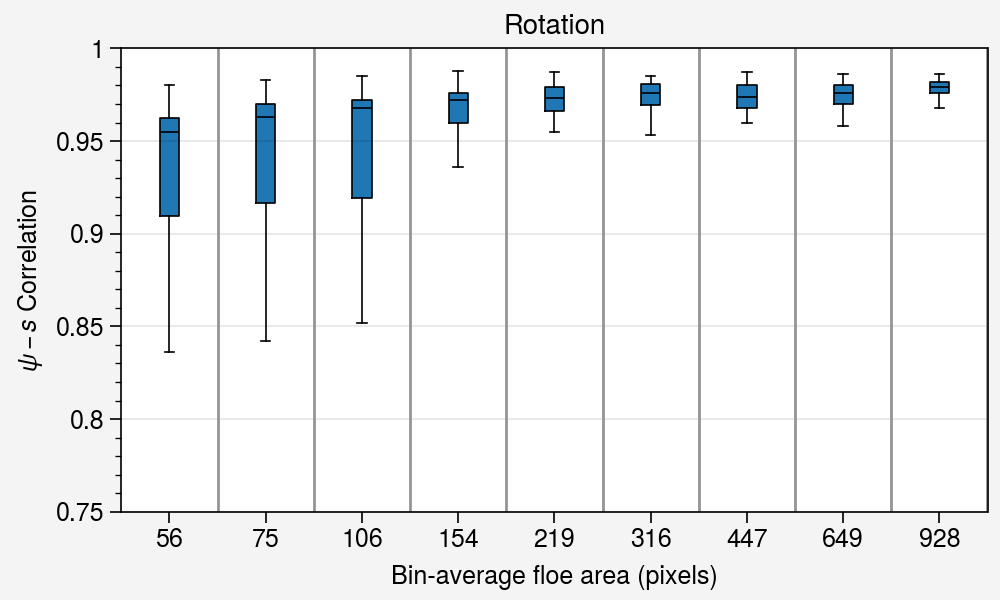

In [65]:
#### Plot ####
fig, axs = pplt.subplots(width=5, height=3, nrows=1, share=False)
ax = axs[0]
h = []
for var, color in zip(['min_psi_s_correlation'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray']):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    plot_data = plot_data.loc[:, bin_count['count'] > 10]
    x = plot_data.columns.astype(int)
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))

    # Draw grid lines
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=plot_range, ylim=(0.75, 1),
          xformatter=[str(int(x)) for x in bin_count.area.round().values.squeeze()], xrotation=0,
         title='Rotation', xlabel='Bin-average floe area (pixels)', ylabel=r'$\psi-s$ Correlation',
         xgrid=False)

For the rotation results, there's a pretty obvious change after the 154 bin. The 95% correlation is often violated for the small floes, and likely is a function of the number of parameterized edge vertices.

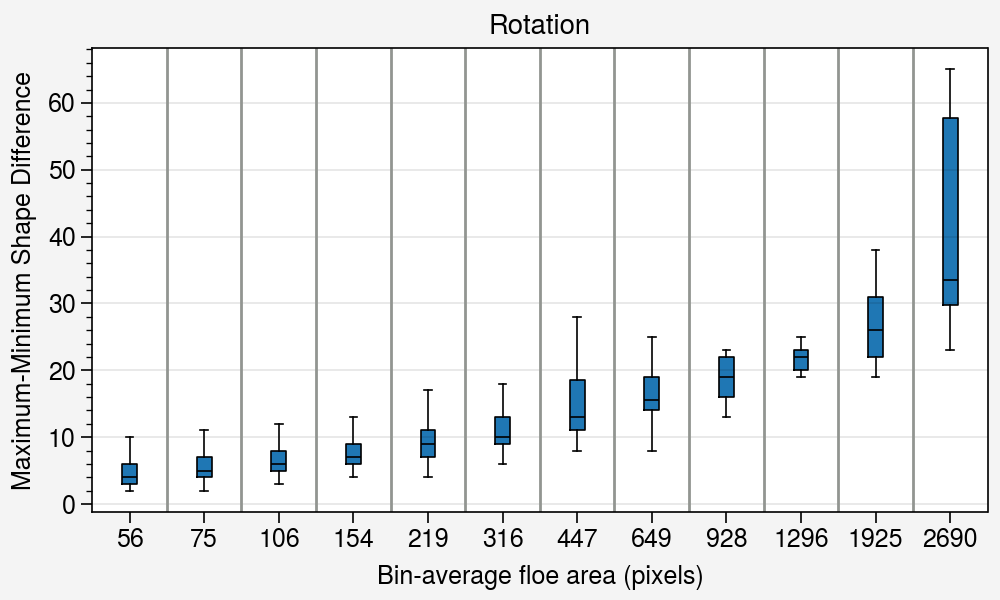

In [66]:
#### Plot ####
fig, axs = pplt.subplots(width=5, height=3, nrows=1, share=False)
ax = axs[0]
h = []
for var, color in zip(['minimum_shape_difference'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray']):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    plot_data = plot_data.loc[:, bin_count['count'] > 10]
    x = plot_data.columns.astype(int)
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))

    # Draw grid lines
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          # xlocator=x, xlim=plot_range, ylim=(0.75, 1),
          xformatter=[str(int(x)) for x in bin_count.area.round().values.squeeze()], xrotation=0,
         title='Rotation', xlabel='Bin-average floe area (pixels)', ylabel='Maximum-Minimum Shape Difference',
         xgrid=False)

In [67]:
df['normalized_sd'] = df['minimum_shape_difference'] / df['perimeter']
df['normalized_sd_area']  = df['minimum_shape_difference'] / df['area']

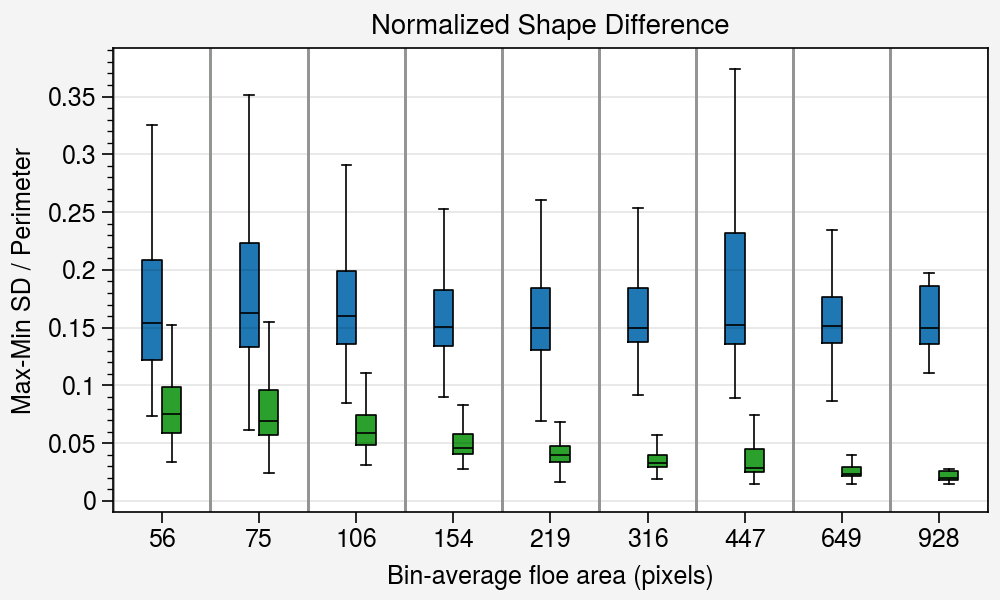

In [68]:
#### Plot ####
fig, axs = pplt.subplots(width=5, height=3, nrows=1, share=False)
ax = axs[0]
h = []
for var, color, offset in zip(['normalized_sd', 'normalized_sd_area'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'], [-0.1, 0.1]):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    plot_data = plot_data.loc[:, bin_count['count'] > 10]
    plot_data.columns += offset
    x = plot_data.columns.astype(int)
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))

    # Draw grid lines
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=plot_range, #ylim=(0.75, 1),
          xformatter=[str(int(x)) for x in bin_count.area.round().values.squeeze()], xrotation=0,
         title='Normalized Shape Difference', xlabel='Bin-average floe area (pixels)', ylabel='Max-Min SD / Perimeter',
         xgrid=False)

## TBD
I'll need to write a Julia script to compute the psi-s correlation and minimum shape difference for the matched pairs.

The perimeter and area are both obvious choices for normalizing the shape difference. The perimeter is more uncertain, because of algorithm issues, but the normalized SD with area decreases with area. It looks like under rotation with this dataset, normalizing by the perimeter is approximately constant, so we could use a single threshold. A future update could interpret it probabilistically too, giving each observation a Z-score.

In [13]:
#### Load the data both for the matches and for the inital images #####
dataloc = '/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/ice_floe_validation_dataset/data/validation_dataset/'

files = os.listdir(dataloc + 'property_tables/matched/')
data = []
for f in files:
    if '.csv' in f:
        data.append(pd.read_csv(dataloc + 'property_tables/matched/' + f))
df_matched = pd.concat(data)

files = os.listdir(dataloc + '/property_tables/aqua/')
data = []
for f in files:
    if '.csv' in f:
        data.append(pd.read_csv(dataloc + '/property_tables/aqua/' + f))
df_aqua = pd.concat(data)


files = os.listdir(dataloc + '/property_tables/terra/')
data = []
for f in files:
    if '.csv' in f:
        data.append(pd.read_csv(dataloc + '/property_tables/terra/' + f))
df_terra = pd.concat(data)

df_matched = df_matched.dropna()
df_matched['case_number'] = [str(int(x)).zfill(3) for x in df_matched['case_number']]
df_terra['case_number'] = [str(int(x)).zfill(3) for x in df_terra['case_number']]
df_aqua['case_number'] = [str(int(x)).zfill(3) for x in df_aqua['case_number']]

df_merged = df_matched.merge(df_aqua[['label', 'case_number', 'axis_major_length', 'axis_minor_length', 'convex_area']], 
                 left_on=['aqua_label', 'case_number'], right_on=['label', 'case_number'],
                 suffixes=[None, '_aqua'], how='inner').merge(
    df_terra[['label', 'case_number', 'axis_major_length', 'axis_minor_length', 'convex_area']], 
                 left_on=['terra_label', 'case_number'], right_on=['label', 'case_number'],
                 suffixes=[None, '_terra'], how='inner')
df_merged.rename({'axis_major_length': 'axis_major_length_aqua',
                  'axis_minor_length': 'axis_minor_length_aqua',
                  'aqua_area': 'area_aqua',
                  'terra_area': 'area_terra',
                  'convex_area': 'convex_area_aqua'}, axis=1, inplace=True)

#### Compute ADRs ####
df_merged['adr_area'] = np.abs(df_merged['area_aqua'] - df_merged['area_terra'])/(df_merged['area_aqua'] + df_merged['area_terra'])
df_merged['adr_major_axis_length'] = np.abs(df_merged['axis_major_length_aqua'] - df_merged['axis_major_length_terra'])/(df_merged['axis_major_length_aqua'] + df_merged['axis_major_length_terra'])
df_merged['adr_minor_axis_length'] = np.abs(df_merged['axis_minor_length_aqua'] - df_merged['axis_minor_length_terra'])/(df_merged['axis_minor_length_aqua'] + df_merged['axis_minor_length_terra'])
df_merged['adr_convex_area'] = np.abs(df_merged['convex_area_aqua'] - df_merged['convex_area_terra'])/(df_merged['convex_area_aqua'] + df_merged['convex_area_terra'])

df_merged['area'] = 1/2*(df_merged['area_aqua'] + df_merged['area_terra'])
df_merged['L'] = np.sqrt(df_merged['area'])
df_merged['area_bin'] = np.digitize(df_merged['area'], bins)

df_merged = df_merged.loc[df_merged.area > 50].copy()
merged_bin_count = df_merged[['area_bin', 'area']].groupby('area_bin').mean()
merged_bin_count['count'] = df_merged[['area_bin', 'area']].groupby('area_bin').count()['area']

# Divide into testing and training datasets
training_idx = df_merged.sample(frac=2/3, random_state=4204).sort_index().index
df_merged['training'] = False
df_merged.loc[training_idx, 'training'] = True

# could make this a function
df_mg = df_merged.loc[training_idx, :].copy()

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_12542/3084273253.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aqua = pd.concat(data)
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_12542/3084273253.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_terra = pd.concat(data)


In [ ]:
#### Plot ####
fig, axs = pplt.subplots(width=5, height=6, nrows=2, share=False)
ax = axs[0]
h = []
for var, color, offset in zip(['max_adr_area', 'max_adr_convex_area',
                       'max_adr_major_axis_length', 'max_adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    plot_data = plot_data.loc[:, bin_count['count'] > 10]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))

    # Draw grid lines
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=plot_range, ylim=(0, 0.3),
          xformatter=[str(int(x)) for x in bin_count.area.round().values.squeeze()], xrotation=0,
         title='Rotation', xlabel='Bin-average floe area (pixels)', ylabel='ADR',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
# fig.save('../figures/maximum_adr_rotation_boxplot.png', dpi=300)


# fig, ax = pplt.subplots(width=6, height=3)
ax = axs[1]
h = []
for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):

    merged_bin_count = df_mg[['area_bin', 'area']].groupby('area_bin').mean()
    merged_bin_count['count'] = df_mg[['area_bin', 'area']].groupby('area_bin').count()['area']

    plot_data = df_mg.pivot_table(columns='area_bin', values=var, index=df_mg.index)
    plot_data = plot_data.loc[:, merged_bin_count['count'] > 10]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=plot_range, ylim=(0, 0.3),
          xformatter=[str(int(x)) for x in merged_bin_count.area.round(1).values.squeeze()], xrotation=0,
         title='Matched Pairs', xlabel='Bin-average floe area (pixels)', ylabel='ADR',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.format(abc=True)
fig.save('../figures/fig_XX_adr_analysis.png', dpi=300)